In [1]:
import argparse
import os
import json
import torch
import pandas as pd
import sys

path_model = '../model' # path to model folder
path_data = '../data/input_create_model/processed' # path to data
path_train_files = f'{path_model}/output/example/' # path to the trained toy model
path_save = './output/explain_postar'
sys.path.append(path_model)

from utils.Utils import prepare_inputs_explainability, read_postar3_data, analyze_results_per_rbp_or_gene, analyze_postar_matrix, calculate_optimal_thresholds_per_rbp
from utils.Plots import plot_boxplot_with_annotations, plot_score_results, plot_one_ktop_rbp_with_thresholds
from utils.Config import Config
from DLModelClass.modelsNN import DeepRBP
from calculate_deeplift_values import perform_deeplift_pipeline, match_scores_and_validation_data

/opt/anaconda3/envs/DeepRBP/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tutorial: DeepRBP explainer on POSTAR3 using a trained model with TCGA

In this tutorial, we will give you an example of how validate DeepRBP explainability module using a POSTAR3 binary matrix from huh7 and HepG2 tumoral liver cell lines, using TCGA Liver Hepatocellular carcinoma samples to calculate the explainability scores

## Define the local variables

In [2]:
tumor_type = 'Liver_Hepatocellular_Carcinoma'
source_explain = 'TCGA'
tumor2tissue = { 
            "Kidney_Chromophobe": "Kidney_embryo_GxRBP",
            "Liver_Hepatocellular_Carcinoma": "Liver_GxRBP", 
            "Acute_Myeloid_Leukemia": "Myeloid_GxRBP"
            } # Choose later one
getBM = pd.read_csv('../data/input_create_model/extra/getBM_reduced.csv', index_col=0) 

In [3]:
print("Welcome again! You're about to perform the explainability of the DeepRBP model")
print(f"The experiments will be shown in {path_save}")
print(f"The path_data used for this explainability is: {path_data}")

Welcome again! You're about to perform the explainability of the DeepRBP model
The experiments will be shown in ./output/explain_postar
The path_data used for this explainability is: ../data/input_create_model/processed


## Create the tissue-specific POSTAR3 file
From the already downloaded *human.txt* file (data under request) containing information on CLIP experiments from POSTAR3, we are going to generate a POSTAR3 file for a specific tissue. 

To do so we are going to run the process_script.sh:
```bash
cd DeepRBP/data/postar3/input_data
bash process_script.sh
```
This shell file executes the script analyze_postar3file.py and performs the following steps:
1) Read general human POSTAR3 file
2) Remove NaNs in RBP name
3) Describe each tissue and create a table > `DeepRBP/data/postar3/input_data/df_tissue_description.txt`
4) Create tissue-specific POSTAR3 files


As an example, we are going to show you the result for Liver:

In [4]:
file_path = './../data/data_postar3/input_data/results/human_Liver.txt'
postar3_liver = pd.read_csv(file_path, index_col=0)
postar3_liver.head()

,RBP_name,chromosome,start,end,raw_tissue,technique,experiment,strand,PhastCons_Score,PhyloP_Score,tissue
0,SF3A3,chr1,187892,187938,HepG2,eCLIP,ENCODE,-,0.018696,-0.186978,Liver
1,U2AF2,chr1,786667,786727,HepG2,eCLIP,ENCODE,+,0.024700,-0.020417,Liver
2,YTHDF2,chr1,819178,819200,Huh7,PAR-CLIP_PARalyzer,GSE83438_GSM2203039,+,0.003364,0.099364,Liver
3,SUGP2,chr1,830236,830282,HepG2,eCLIP,ENCODE,+,0.016152,-0.078478,Liver
4,SUGP2,chr1,830238,830290,HepG2,eCLIP,ENCODE,+,0.017500,-0.082231,Liver


In [5]:
print(f'shape of Liver postar file: {postar3_liver.shape}')

shape of Liver postar file: (42358, 11)


## Create the tissue-specific Postar3 GxRBP binary matrix
After creating the POSTAR3 files for each tissue, which contain information about RBPs detected in specific genomic regions from CLIP experiments (in this case, liver), we generate the GxRBP matrix using the **_create_gxrbp.R_** script and these inputs, in addition to the Postar3 file:

- **_EventsFound_gencode23.txt_**: Information about the events: position, event type, name, ID, etc.
- **_Events_Regions_gc23_400nt.RData_**: Event regions


Execute this code in terminal:
```bash
cd DeepRBP/data/postar3/create_gxrbp
Rscript create_gxrbp.R
```
### Brief Function Explanation

This R script generates a matrix representing the relationships between splicing events (Events) and RNA-binding proteins (RBPs). The resulting GxS matrix indicates relationships between genes and RBPs, with a value of 1 indicating an overlap between a gene and an RBP in splicing events. The script processes data from POSTAR3 and splicing events for different tissues, producing output CSV files in a directory named `./results`.

On the other hand, in `./readme.md` you'll find a detailed explanation of the R file.

## Load POSTAR3 experimenental data with GxRBP relationships

In [6]:
df_val_GxRBP = read_postar3_data('../data/data_postar3', tumor_type, tumor2tissue)
df_val_GxRBP.head()

[explainability][read_validation_data] The selected tissue test used to do the explainability is: Liver_Hepatocellular_Carcinoma
[explainability][read_validation_data] For this tissue you have just this Postar data available: Liver_GxRBP
[explainability][read_validation_data] Loading Postar data ...


,AGGF1,AKAP1,AQR,BCCIP,BCLAF1,BUD13,CDC40,CSTF2,CSTF2T,DDX3X,...,WDR43,XPO5,XRCC6,XRN2,YBX3,YTHDF1,YTHDF2,YTHDF3,ZC3H11A,ZNF800
ENSG00000000003,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000457,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000460,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(f"Shape: {df_val_GxRBP.shape}")

Shape: (20597, 107)


Note that there are many fewer RBPs and more genes than what we considered for the modeling. This matrix is filtered to only consider the genes that we considered in DeepRBP, and for the RBPs not considered in POSTAR3, we set them to NaN.

## Analyze the POSTAR3 matrix 

In [8]:
count_1 = (df_val_GxRBP.values.flatten() == 1).sum()
count_0 = (df_val_GxRBP.values.flatten() == 0).sum()
print(f"Number of 1s: {count_1}")
print(f"Number of 0s: {count_0}")

Number of 1s: 141511
Number of 0s: 2062368


## Load the configuration class of the trained model
Now we are going to load the configuration of the trained model with TCGA loading a `.json` file into a dictionary. 

In [9]:
with open(f'{path_train_files}/config.json', 'r') as file:
    config_dict = json.load(file)
print(config_dict)

{'max_node': 1024, 'num_hidden_layers': 2, 'learning_rate': 0.001, 'batch_size': 8, 'epochs': 1000, 'same_num_nodes': True, 'node_divition_factor': 8, 'activation_layer': 'relu', 'optimizer': 'adamW', 'source_train': 'TCGA', 'train_tumor_types': 'all', 'test_tumor_types': 'all'}


This dictionary contains the parameters used to train the DeepRBP predictor using all TCGA tumor types to train the model. Note that in this case same_num_nodes is not necessary as the number of hidden layers is lower than 3.

Afterwards we will change the `test_tumor_types` variable to the desired tumor type samples, as we will perform the explainability module just with this tumor type. The explainability module is intended to be done using one tumor type at a time. In this case liver hepatocellular carcinoma. With this information we will create and fill the `Config`object.

In [10]:
# Select the tumor type to be tested in the explainability and load the final config_obj
config_dict['test_tumor_types'] = tumor_type
config_obj = Config(**config_dict)
print(f'Samples selected to perform the explainability with POSTAR3: {config_obj.test_tumor_types}')

Samples selected to perform the explainability with POSTAR3: Liver_Hepatocellular_Carcinoma


## Prepare input data samples for DeepRBP

In [11]:
data_inputs = prepare_inputs_explainability(tumor_type, source_explain, config_obj, path_data, path_train_files)

[prepare_inputs_explainability] Explainability is going to be performed for: Liver_Hepatocellular_Carcinoma of source TCGA
[Utils][get_data] set_mode is test
[Utils][get_data] We are not selecting all the tumor types
['Liver_Hepatocellular_Carcinoma']
[Utils][get_data] path_raw:  ../data/input_create_model/processed/splitted_datasets/TCGA/test/Liver_Hepatocellular_Carcinoma
[Utils][get_data] tumor_type & source columns added to this set ... -> DONE
[Utils][get_data] path_raw:  ../data/input_create_model/processed/splitted_datasets/GTEX/test/Liver
[Utils][get_data] tumor_type & source columns added to this set ... -> DONE
[prepare_inputs_explainability] Read Test data ... -> DONE
[prepare_inputs_explainability] Select just the samples of the TCGA source and remove column 'source' & 'tumor_type'... -> DONE
[utils][get_scaled_rbp_test_data] Scale test data with the scaler used in Training ... -> DONE 
[prepare_inputs_explainability] Load the scaler and sigma vale used for SF data in model

In data_inputs we contain the following information of the test set of liver hepatocellular carcinoma:
- df_scaled_test: (DataFrame) the scaled and normalized log2(TPM+1) RBP expression data in [0-1] (`n_samples x RBPs`).
- test_labels: (DataFrame) the transcript expression data in log2(TPM+1) (`n_samples x transcripts`).
- test_gn: DataFrame) the gene expression data of each transcript in TPMs (`n_samples x transcripts`).

In [12]:
data_inputs.df_scaled_test.head()

,A1CF,AATF,ABCF1,ABT1,ACAA2,ACIN1,ACTB,ACTN1,ACTN4,ADAR,...,ZNF598,ZNF622,ZNF638,ZNF768,ZNFX1,ZNHIT6,ZRANB2,ZRSR1,ZRSR2,ZYX
TCGA-DD-A39V-01,1.0,0.618212,0.124688,0.012490,0.588729,0.00000,0.460036,0.000000,0.000000,0.060948,...,0.000000,0.602074,0.337372,0.007778,0.034133,0.000000,0.000000,0.362310,0.000000,0.176397
TCGA-DD-AAD3-01,1.0,0.249162,0.644829,0.507840,0.876843,0.00147,0.267463,0.387333,0.327593,0.425679,...,0.435151,0.379514,0.112096,0.291670,0.196547,0.107154,0.216800,0.319466,0.000087,0.467775
TCGA-BC-A110-11,1.0,0.000000,0.087211,0.223253,1.000000,0.00000,0.060612,0.239439,0.000000,0.000000,...,0.200592,0.248815,0.083325,0.000000,0.061637,0.000000,0.000000,0.319466,0.000000,0.336591
TCGA-ES-A2HT-11,1.0,0.000000,0.275138,0.268314,1.000000,0.00000,0.150647,0.253939,0.018687,0.353955,...,0.244500,0.305334,0.349894,0.176734,0.673167,0.001740,0.078694,0.319466,0.000000,0.267445
TCGA-DD-A3A3-11,1.0,0.047807,0.134242,0.349566,1.000000,0.00000,0.077681,0.237681,0.000000,0.000000,...,0.071121,0.478531,0.197653,0.073263,0.000000,0.000000,0.000000,0.319466,0.000000,0.184006


In [13]:
data_inputs.test_labels.head()

,ENST00000006015,ENST00000006750,ENST00000009530,ENST00000027335,ENST00000034275,ENST00000052569,ENST00000053243,ENST00000066544,ENST00000074304,ENST00000078429,...,ENST00000631199,ENST00000631253,ENST00000631589,ENST00000631641,ENST00000631857,ENST00000632133,ENST00000632375,ENST00000633063,ENST00000633317,ENST00000633691
TCGA-DD-A39V-01,0.0,0.000000,4.907344,0.000000,0.000000,0.000000,0.000000,1.636897,0.575314,2.724686,...,0.000000,0.0,0.226513,0.0,0.000000,0.389570,0.0,0.056585,0.0,0.084067
TCGA-DD-AAD3-01,0.0,0.275004,7.028978,0.000000,2.881647,2.408694,0.097613,2.821681,1.280942,3.769736,...,0.070387,0.0,0.000000,0.0,0.097613,0.226513,0.0,1.875795,0.0,0.298665
TCGA-BC-A110-11,0.0,0.000000,5.371540,0.000000,1.372931,1.163497,0.000000,2.560735,0.722454,3.204754,...,0.000000,0.0,0.000000,0.0,0.000000,0.344836,0.0,1.250954,0.0,0.000000
TCGA-ES-A2HT-11,0.0,1.256998,6.763527,0.056585,0.815589,2.100958,1.070382,2.748489,1.220324,3.584997,...,0.000000,0.0,0.000000,0.0,0.000000,0.286878,0.0,1.996368,0.0,0.432948
TCGA-DD-A3A3-11,0.0,1.137484,7.117814,0.014355,0.918387,0.831880,0.214120,2.275021,0.848008,3.456820,...,0.000000,0.0,0.000000,0.0,0.028568,0.111034,0.0,1.367348,0.0,0.000000


In [14]:
data_inputs.test_gn.head()

,ENST00000006015,ENST00000006750,ENST00000009530,ENST00000027335,ENST00000034275,ENST00000052569,ENST00000053243,ENST00000066544,ENST00000074304,ENST00000078429,...,ENST00000631199,ENST00000631253,ENST00000631589,ENST00000631641,ENST00000631857,ENST00000632133,ENST00000632375,ENST00000633063,ENST00000633317,ENST00000633691
TCGA-DD-A39V-01,0.0,3.520036,1306.959659,0.000000,18.309509,1.669986,0.000000,2.920076,0.549991,6.449898,...,3.720025,3.370055,1.739980,9.929732,0.030000,3736.313029,3.699961,2.040034,3.699961,67.770181
TCGA-DD-AAD3-01,0.0,1.999971,834.806644,0.060002,21.000202,4.860158,0.089999,15.400511,2.200062,12.689702,...,0.479997,15.209546,6.810158,29.239580,0.530006,5852.753300,4.789911,3.160042,4.789911,38.000909
TCGA-BC-A110-11,0.0,2.100035,438.063653,0.020000,10.850330,3.540106,0.000000,6.169982,0.750008,9.180310,...,0.840013,6.329853,2.640029,73.822079,0.099998,2915.847404,3.470117,3.969994,3.470117,19.929417
TCGA-ES-A2HT-11,0.0,4.150118,1236.630547,0.040001,11.520048,4.329999,1.099989,9.620088,1.750025,11.359859,...,0.299993,6.879913,5.310061,26.279121,0.310003,12969.182191,4.279858,5.990013,4.279858,29.800231
TCGA-DD-A3A3-11,0.0,3.630083,1191.611957,0.010000,11.260288,3.030013,0.540000,5.529845,0.909986,10.189832,...,0.310003,5.749949,3.569930,33.969252,0.109998,4930.094918,4.799884,3.730097,4.799884,27.149371


## Load the trained model

In [15]:
model = DeepRBP(n_inputs=data_inputs.df_scaled_test.shape[1], n_outputs=data_inputs.test_labels.shape[1], config=config_obj, device=data_inputs.device)
model.load_state_dict(torch.load(path_train_files+'/model.pt', map_location=data_inputs.device))      
model.eval()

You are using a model with 2 hidden layers


DeepRBP(
  (linear0): Linear(in_features=1282, out_features=1024, bias=True)
  (bn0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a_function0): ReLU()
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a_function1): ReLU()
  (final_layer): Linear(in_features=128, out_features=11462, bias=True)
)

# Perform DeepLIFT method: calculate TxRBP and GxRBP scores

We are going to calculate the DeepLIFT scores using the test set of Liver TCGA expression data.

The DeepRBP model is integrated into the DeepLIFT explainer, and for each of the transcripts and samples, the contribution of each RBP is calculated. This is done using the RBP expression data, the gene expression data, and a zeros vector reference (select_reference: `knockout`) of the RBPs. This reference is necessary to run DeepLIFT.

The scores across samples are then aggregated by calculating the t-statistic (method:`tstat`) score, resulting in the `df_deeplift_scores_TxRBP` scores. Subsequently, the scores are collapsed to genes (`df_deeplift_scores_GxRBP`) by selecting, for each gene, the transcript with the highest absolute score. To do so a getBM relating transcripts ids to gene ids is fitted.

In `./output/explain_postar` you will see the score dataframes saved and some plots comparing the scores with POSTAR3 classes across RBPs and across genes.

In [ ]:
df_deeplift_scores_TxRBP, df_deeplift_scores_GxRBP = perform_deeplift_pipeline(
                                                        df_scaled_test = data_inputs.df_scaled_test, 
                                                        test_labels = data_inputs.test_labels, 
                                                        test_gn = data_inputs.test_gn, 
                                                        model = model, 
                                                        path_save = path_save, 
                                                        getBM = getBM, 
                                                        select_reference='knockout', 
                                                        method='tstat'
                                                        )

[calculate_rbp_reference] You selected the knockout RBP expression as reference
reference of the RBP expression: tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
[calculate_rbp_reference] Calculate the reference of the RBP expression data: knockout of the test data ... -> DONE
[perform_deeplift_pipeline] Calculate the reference of the RBP expression data ... -> DONE
[perform_deeplift_pipeline] reference of the RBP expression: tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
[perform_deeplift_pipeline] Calculate shapley scores with DeepLIFT
[create_deeplift_scores_dataframe] DeepLIFT in the output layer nodes


Calculating scores:  79%|████████████▋   | 9084/11462 [42:25<19:50,  2.00node/s]

In [ ]:
df_deeplift_scores_TxRBP

In [30]:
df_deeplift_scores_GxRBP

,A1CF,AATF,ABCF1,ABT1,ACAA2,ACIN1,ACTB,ACTN1,ACTN4,ADAR,...,ZNF598,ZNF622,ZNF638,ZNF768,ZNFX1,ZNHIT6,ZRANB2,ZRSR1,ZRSR2,ZYX
ENSG00000000971,35.026180,15.960286,18.620102,21.463892,17.946428,13.614940,15.464704,15.534584,18.408028,21.234512,...,23.065414,24.061241,25.172752,22.694914,16.636965,10.630508,14.727562,43.136856,11.305437,19.508087
ENSG00000002834,15.197975,20.461561,20.425703,15.756799,31.123774,12.364808,13.307159,17.842253,16.851055,19.573252,...,14.644515,18.188025,22.231741,16.796553,16.799784,8.321851,12.853643,20.132032,9.138660,16.209291
ENSG00000003400,54.995110,18.107038,18.572203,20.341236,26.790915,13.585782,13.488997,18.763474,18.489227,18.899191,...,18.695650,19.649433,24.717106,20.383659,13.259379,10.026250,13.764035,28.157803,9.416736,18.258066
ENSG00000003402,55.474636,20.009888,25.978497,23.824503,52.290588,12.855947,14.674993,22.968901,15.930600,20.679594,...,21.447077,22.715158,27.211355,20.712488,16.123697,10.806360,14.795492,40.726509,12.083012,19.088335
ENSG00000004897,23.354584,20.355526,19.720428,16.871996,63.019245,13.531621,15.308624,18.478361,17.580008,21.461536,...,22.224119,24.157478,32.503750,20.456228,16.996864,9.669377,15.028084,51.629368,10.539166,17.671259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000271425,28.869072,19.570932,13.951823,10.379322,23.118494,12.042077,13.831438,9.383667,15.043469,13.754308,...,17.502823,18.465698,16.545053,8.168098,7.827438,9.070186,7.405255,29.155613,9.198316,10.726475
ENSG00000272333,19.120018,19.025602,21.946039,21.104376,17.679548,12.885626,15.205577,19.148661,16.317875,23.545933,...,23.243505,25.593180,26.586657,21.688662,17.202345,11.197189,13.241305,28.871376,11.227943,18.546606
ENSG00000275023,22.876593,15.548753,22.110064,16.178434,38.390938,11.634721,11.193383,13.950513,14.401196,15.830712,...,13.031395,14.406337,22.597809,18.221563,11.738585,9.854260,10.442915,18.249363,7.807403,13.750660
ENSG00000278139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Compare GxRBP scores with POSTAR3 binary matrix

## Force the matching of the shapes of df_val_GxRBP with the DeepLIFT GxRBP

We are going to process the Postar3 validation matrix to have the same shape to the score matrix, adding a NaN for the RBP-Gene non-known regulations

In [84]:
df_deeplift_scores_GxRBP, df_val_nan_included_GxRBP = match_scores_and_validation_data(
                                        df_val_GxRBP=df_val_GxRBP, 
                                        df_score_GxRBP=df_deeplift_scores_GxRBP, 
                                        score_method=f"{select_reference}_{method}"
                                    )    

[match_scores_and_validation_data] Find the matching and non-matching genes and RBPs between the Scores dataframe and Postar ... -> DONE
[match_scores_and_validation_data] Create the df_val_nan_included_GxRBP dataframe with NaN values for the RBPs and genes where we have Scores scores and reorder rows and columns ... -> DONE
[match_scores_and_validation_data] Reorder the rows and cols of the dataframes ... -> DONE
[match_scores_and_validation_data] You're NOT saving any file



In [85]:
df_val_nan_included_GxRBP.head()

,A1CF,AATF,ABCF1,ABT1,ACAA2,ACIN1,ACTB,ACTN1,ACTN4,ADAR,...,ZNF598,ZNF622,ZNF638,ZNF768,ZNFX1,ZNHIT6,ZRANB2,ZRSR1,ZRSR2,ZYX
ENSG00000000971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000002834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000003400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000003402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000004897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analize the processed POSTAR3 matrix
We are going to count how many 1s, 0s and NaN they are in the POSTAT3 matrix and create result dataframes ordering across RBPs and across genes by the number of 1s.

Number of RBPs per Gene:    Class 0  Class 1  Class NaN            Genes
0       95        1       1186  ENSG00000000971
1       56       40       1186  ENSG00000002834
2       89        7       1186  ENSG00000003400
3       74       22       1186  ENSG00000003402
4       81       15       1186  ENSG00000004897
Number of genes per RBP:    Class 0  Class 1  Class NaN   RBPs
0        0        0       1040   A1CF
1        0        0       1040   AATF
2        0        0       1040  ABCF1
3        0        0       1040   ABT1
4        0        0       1040  ACAA2


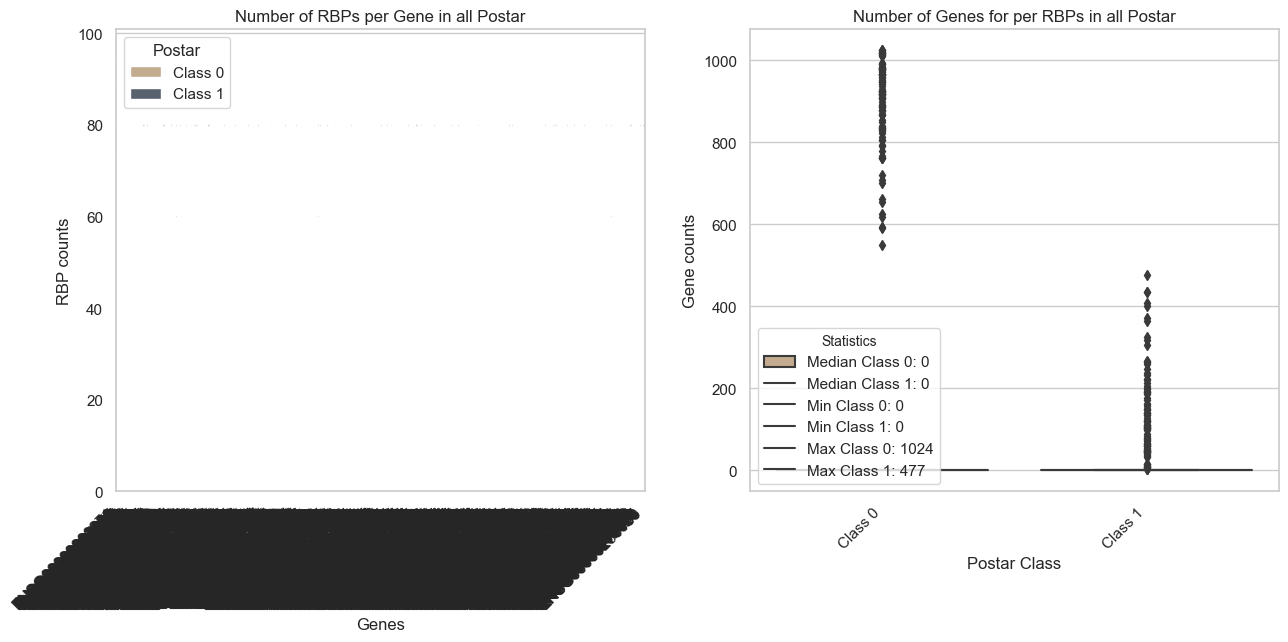

In [106]:
analyze_postar_matrix(df_val_nan_included_GxRBP, path_save)

## Plot results across RBPs and genes

We are going to plot some examples of the GxRBP scores across RBPs and across RBPs to compare the different POSTAR3 classes (0, 1 and NaN). This following code is included inside the utils package in `analyze_results_per_rbp_or_gene`. But now we will go through it step by step.

In [90]:
# Step 1. 
df_count_genes_per_rbp = pd.read_csv(f'{path_save}/Postar/df_count_genes_per_rbp_nan_included_all_Postar.csv', index_col=0)
df_count_rbps_per_gen = pd.read_csv(f'{path_save}/Postar/df_count_rbps_per_gen_nan_included_all_Postar.csv', index_col=0)

list_rbps_postar = df_count_genes_per_rbp.sort_values(by='Class 1', ascending=False)['RBPs'].values.tolist()[0:4]
list_genes_postar = df_count_rbps_per_gen.sort_values(by='Class 1', ascending=False)['Genes'].values.tolist()[0:4]

In [91]:
print(list_rbps_postar)

['GRWD1', 'EFTUD2', 'BCLAF1', 'PPIG']


In [92]:
df_count_genes_per_rbp[df_count_genes_per_rbp.RBPs.isin(list_rbps_postar)].sort_values(by='Class 1', ascending=False)

,Class 0,Class 1,Class NaN,RBPs
369,550,477,13,GRWD1
247,591,436,13,EFTUD2
53,593,434,13,BCLAF1
736,618,409,13,PPIG


In [93]:
df_score_GxRBP=df_deeplift_scores_GxRBP
num_trans_per_gene = getBM.Gene_ID.value_counts()

# Step 2. Calculate the melted dataframe across RBPs with scores and Postar class
# Reorder the score dataframes 
df_score_top_rbps_GxRBP = df_score_GxRBP.copy()
df_val_top_rbps_GxRBP = df_val_nan_included_GxRBP.copy()
df_score_top_rbps_GxRBP = df_score_top_rbps_GxRBP.loc[:,list_rbps_postar]
df_val_top_rbps_GxRBP = df_val_top_rbps_GxRBP.loc[:,list_rbps_postar]

# Melt the information of scores and postar classes
df_score_melted = df_score_top_rbps_GxRBP.reset_index().melt(id_vars=['index'], var_name='RBP_name', value_name='Scores')
df_val_melted = df_val_top_rbps_GxRBP.reset_index().melt(id_vars=['index'], var_name='RBP_name', value_name='Postar')
df_score_melted.rename(columns={'index': 'Gene_ID'}, inplace=True)
df_val_melted.rename(columns={'index': 'Gene_ID'}, inplace=True)
df_combined1 = pd.merge(df_score_melted, df_val_melted, on=['Gene_ID','RBP_name'], how='inner')
df_combined1['Num_Trans_Per_Gene'] = df_combined1['Gene_ID'].map(num_trans_per_gene)

# Step 2. Calculate the melted dataframe across genes with scores and Postar class
# Filter the score dataframes 
df_score_top_genes_GxRBP = df_score_GxRBP.copy()
df_val_top_genes_GxRBP = df_val_nan_included_GxRBP.copy()
df_score_top_genes_GxRBP = df_score_top_genes_GxRBP.loc[list_genes_postar,:]
df_val_top_genes_GxRBP = df_val_top_genes_GxRBP.loc[list_genes_postar,:]

# Melt the information of scores and postar classes
df_score_melted = df_score_top_genes_GxRBP.reset_index().melt(id_vars=['index'], var_name='RBP_name', value_name='Scores')
df_val_melted = df_val_top_genes_GxRBP.reset_index().melt(id_vars=['index'], var_name='RBP_name', value_name='Postar')
df_score_melted.rename(columns={'index': 'Gene_ID'}, inplace=True)
df_val_melted.rename(columns={'index': 'Gene_ID'}, inplace=True)
df_combined2 = pd.merge(df_score_melted, df_val_melted, on=['Gene_ID','RBP_name'], how='inner')

In [94]:
# Result dataframes
df_combined1

,Gene_ID,RBP_name,Scores,Postar,Num_Trans_Per_Gene
0,ENSG00000000971,GRWD1,23.088850,0.0,6
1,ENSG00000002834,GRWD1,17.289450,1.0,9
2,ENSG00000003400,GRWD1,22.814520,1.0,13
3,ENSG00000003402,GRWD1,19.491344,1.0,25
4,ENSG00000004897,GRWD1,18.007605,1.0,19
...,...,...,...,...,...
4155,ENSG00000271425,PPIG,15.850352,0.0,7
4156,ENSG00000272333,PPIG,20.834768,1.0,5
4157,ENSG00000275023,PPIG,15.471545,1.0,11
4158,ENSG00000278139,PPIG,0.000000,NaN,1


In [95]:
df_combined2

,Gene_ID,RBP_name,Scores,Postar
0,ENSG00000184640,A1CF,35.349087,NaN
1,ENSG00000136068,A1CF,47.504147,NaN
2,ENSG00000082898,A1CF,27.357466,NaN
3,ENSG00000104419,A1CF,40.147717,NaN
4,ENSG00000184640,AATF,19.461763,NaN
...,...,...,...,...
5123,ENSG00000104419,ZRSR2,11.079154,NaN
5124,ENSG00000184640,ZYX,17.532539,NaN
5125,ENSG00000136068,ZYX,21.745901,NaN
5126,ENSG00000082898,ZYX,15.840872,NaN


[[('BCLAF1', 0), ('BCLAF1', 1)], [('EFTUD2', 0), ('EFTUD2', 1)], [('GRWD1', 0), ('GRWD1', 1)], [('PPIG', 0), ('PPIG', 1)]]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCLAF1_1 vs. BCLAF1_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.241e-36 U_stat=1.877e+05
PPIG_1 vs. PPIG_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.279e-40 U_stat=1.882e+05
EFTUD2_1 vs. EFTUD2_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.317e-44 U_stat=1.947e+05
GRWD1_1 vs. GRWD1_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.674e-41 U_stat=1.952e+05
[[('ENSG00000082898', 0), ('ENSG00000082898', 1)], [('ENSG00000104419', 0), ('ENSG00000104419', 1)], [('ENSG00000136068', 0), ('ENSG00000136068', 1)], [('ENSG00000184640', 0), ('ENSG00000184640', 1)]]
p-valu

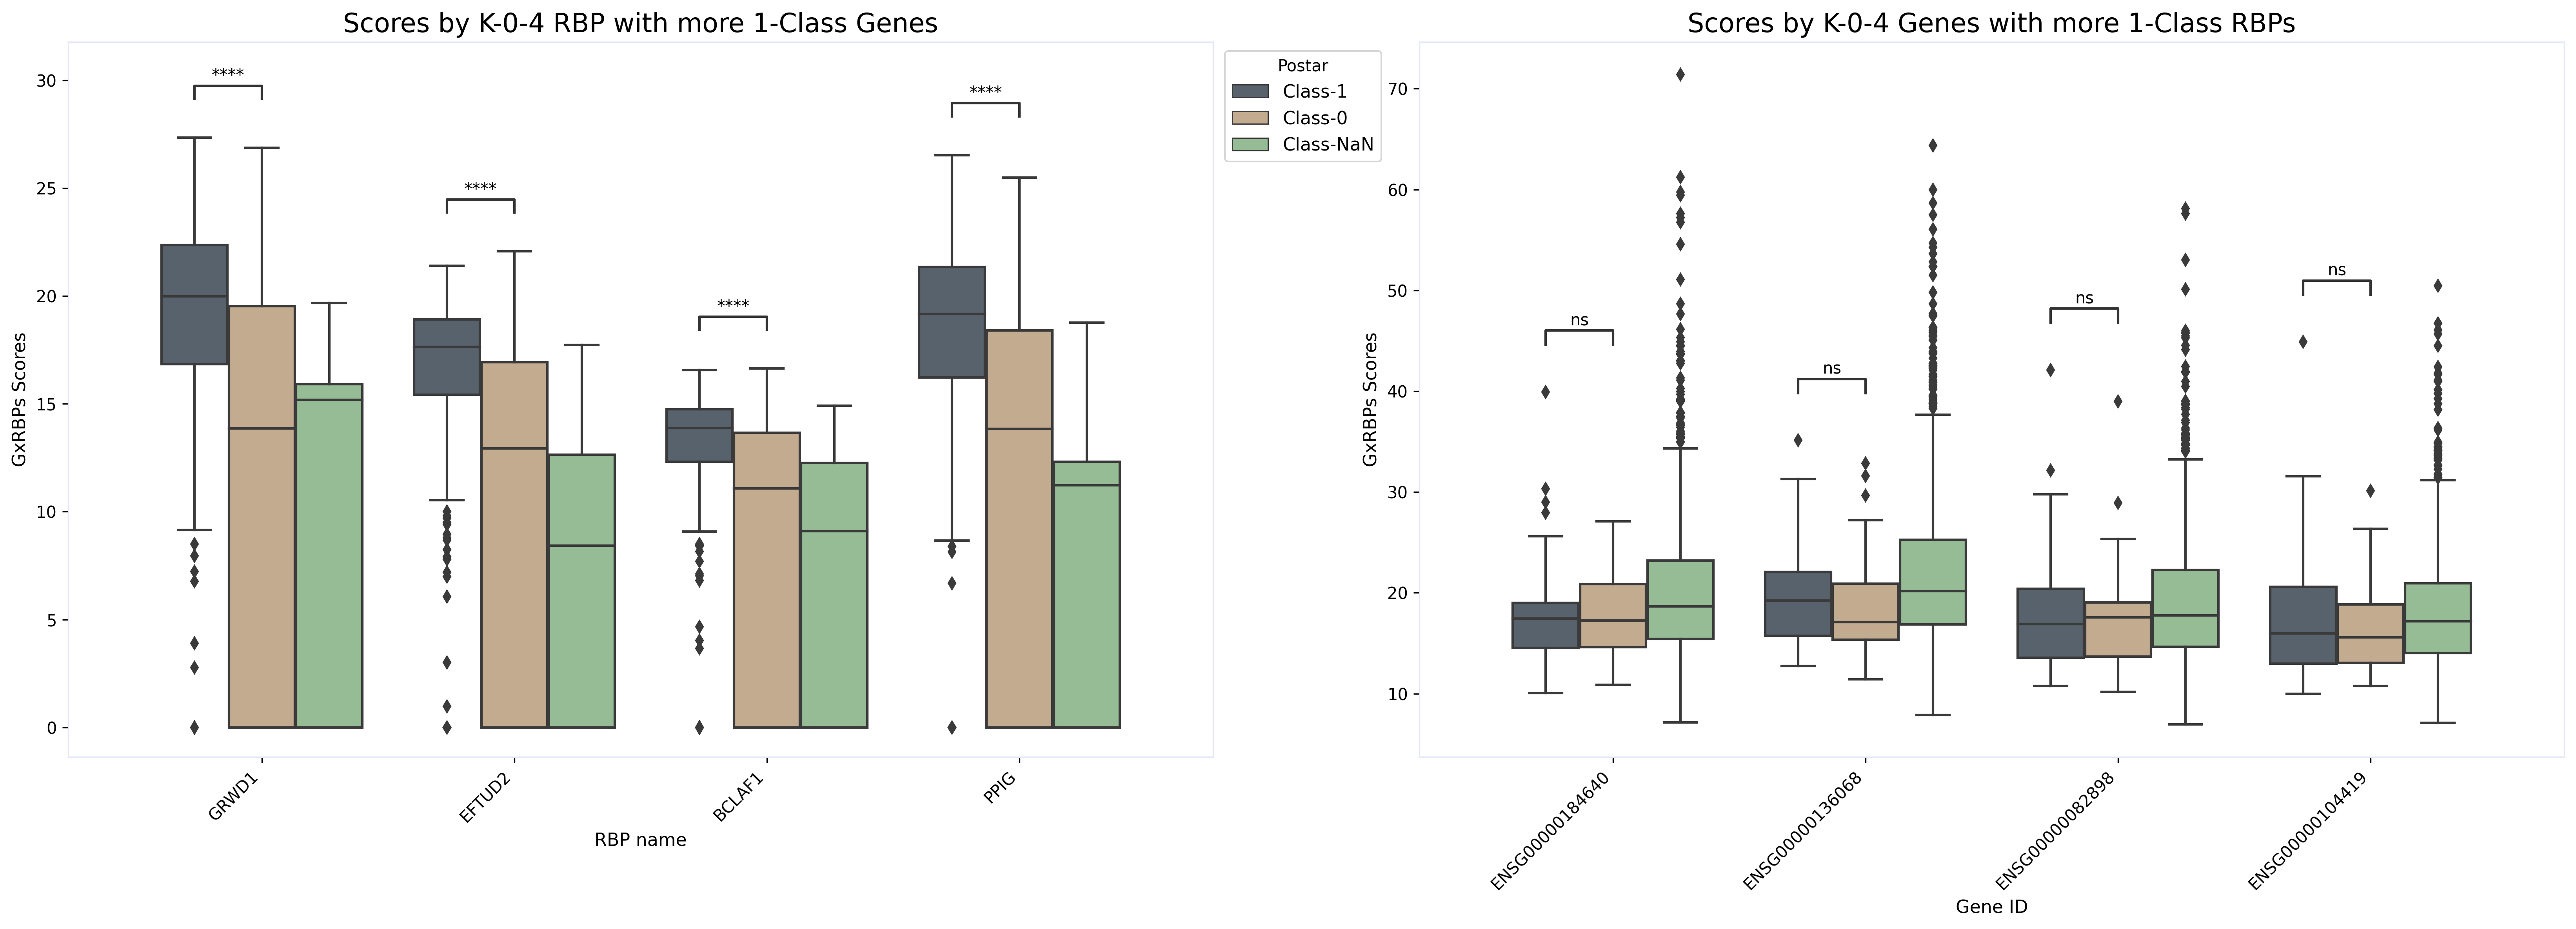

[[('BCLAF1', 0), ('BCLAF1', 1)], [('EFTUD2', 0), ('EFTUD2', 1)], [('GRWD1', 0), ('GRWD1', 1)], [('PPIG', 0), ('PPIG', 1)]]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCLAF1_1 vs. BCLAF1_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.935e-17 U_stat=1.690e+05
PPIG_1 vs. PPIG_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.928e-31 U_stat=1.810e+05
EFTUD2_1 vs. EFTUD2_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.901e-19 U_stat=1.711e+05
GRWD1_1 vs. GRWD1_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.398e-21 U_stat=1.768e+05


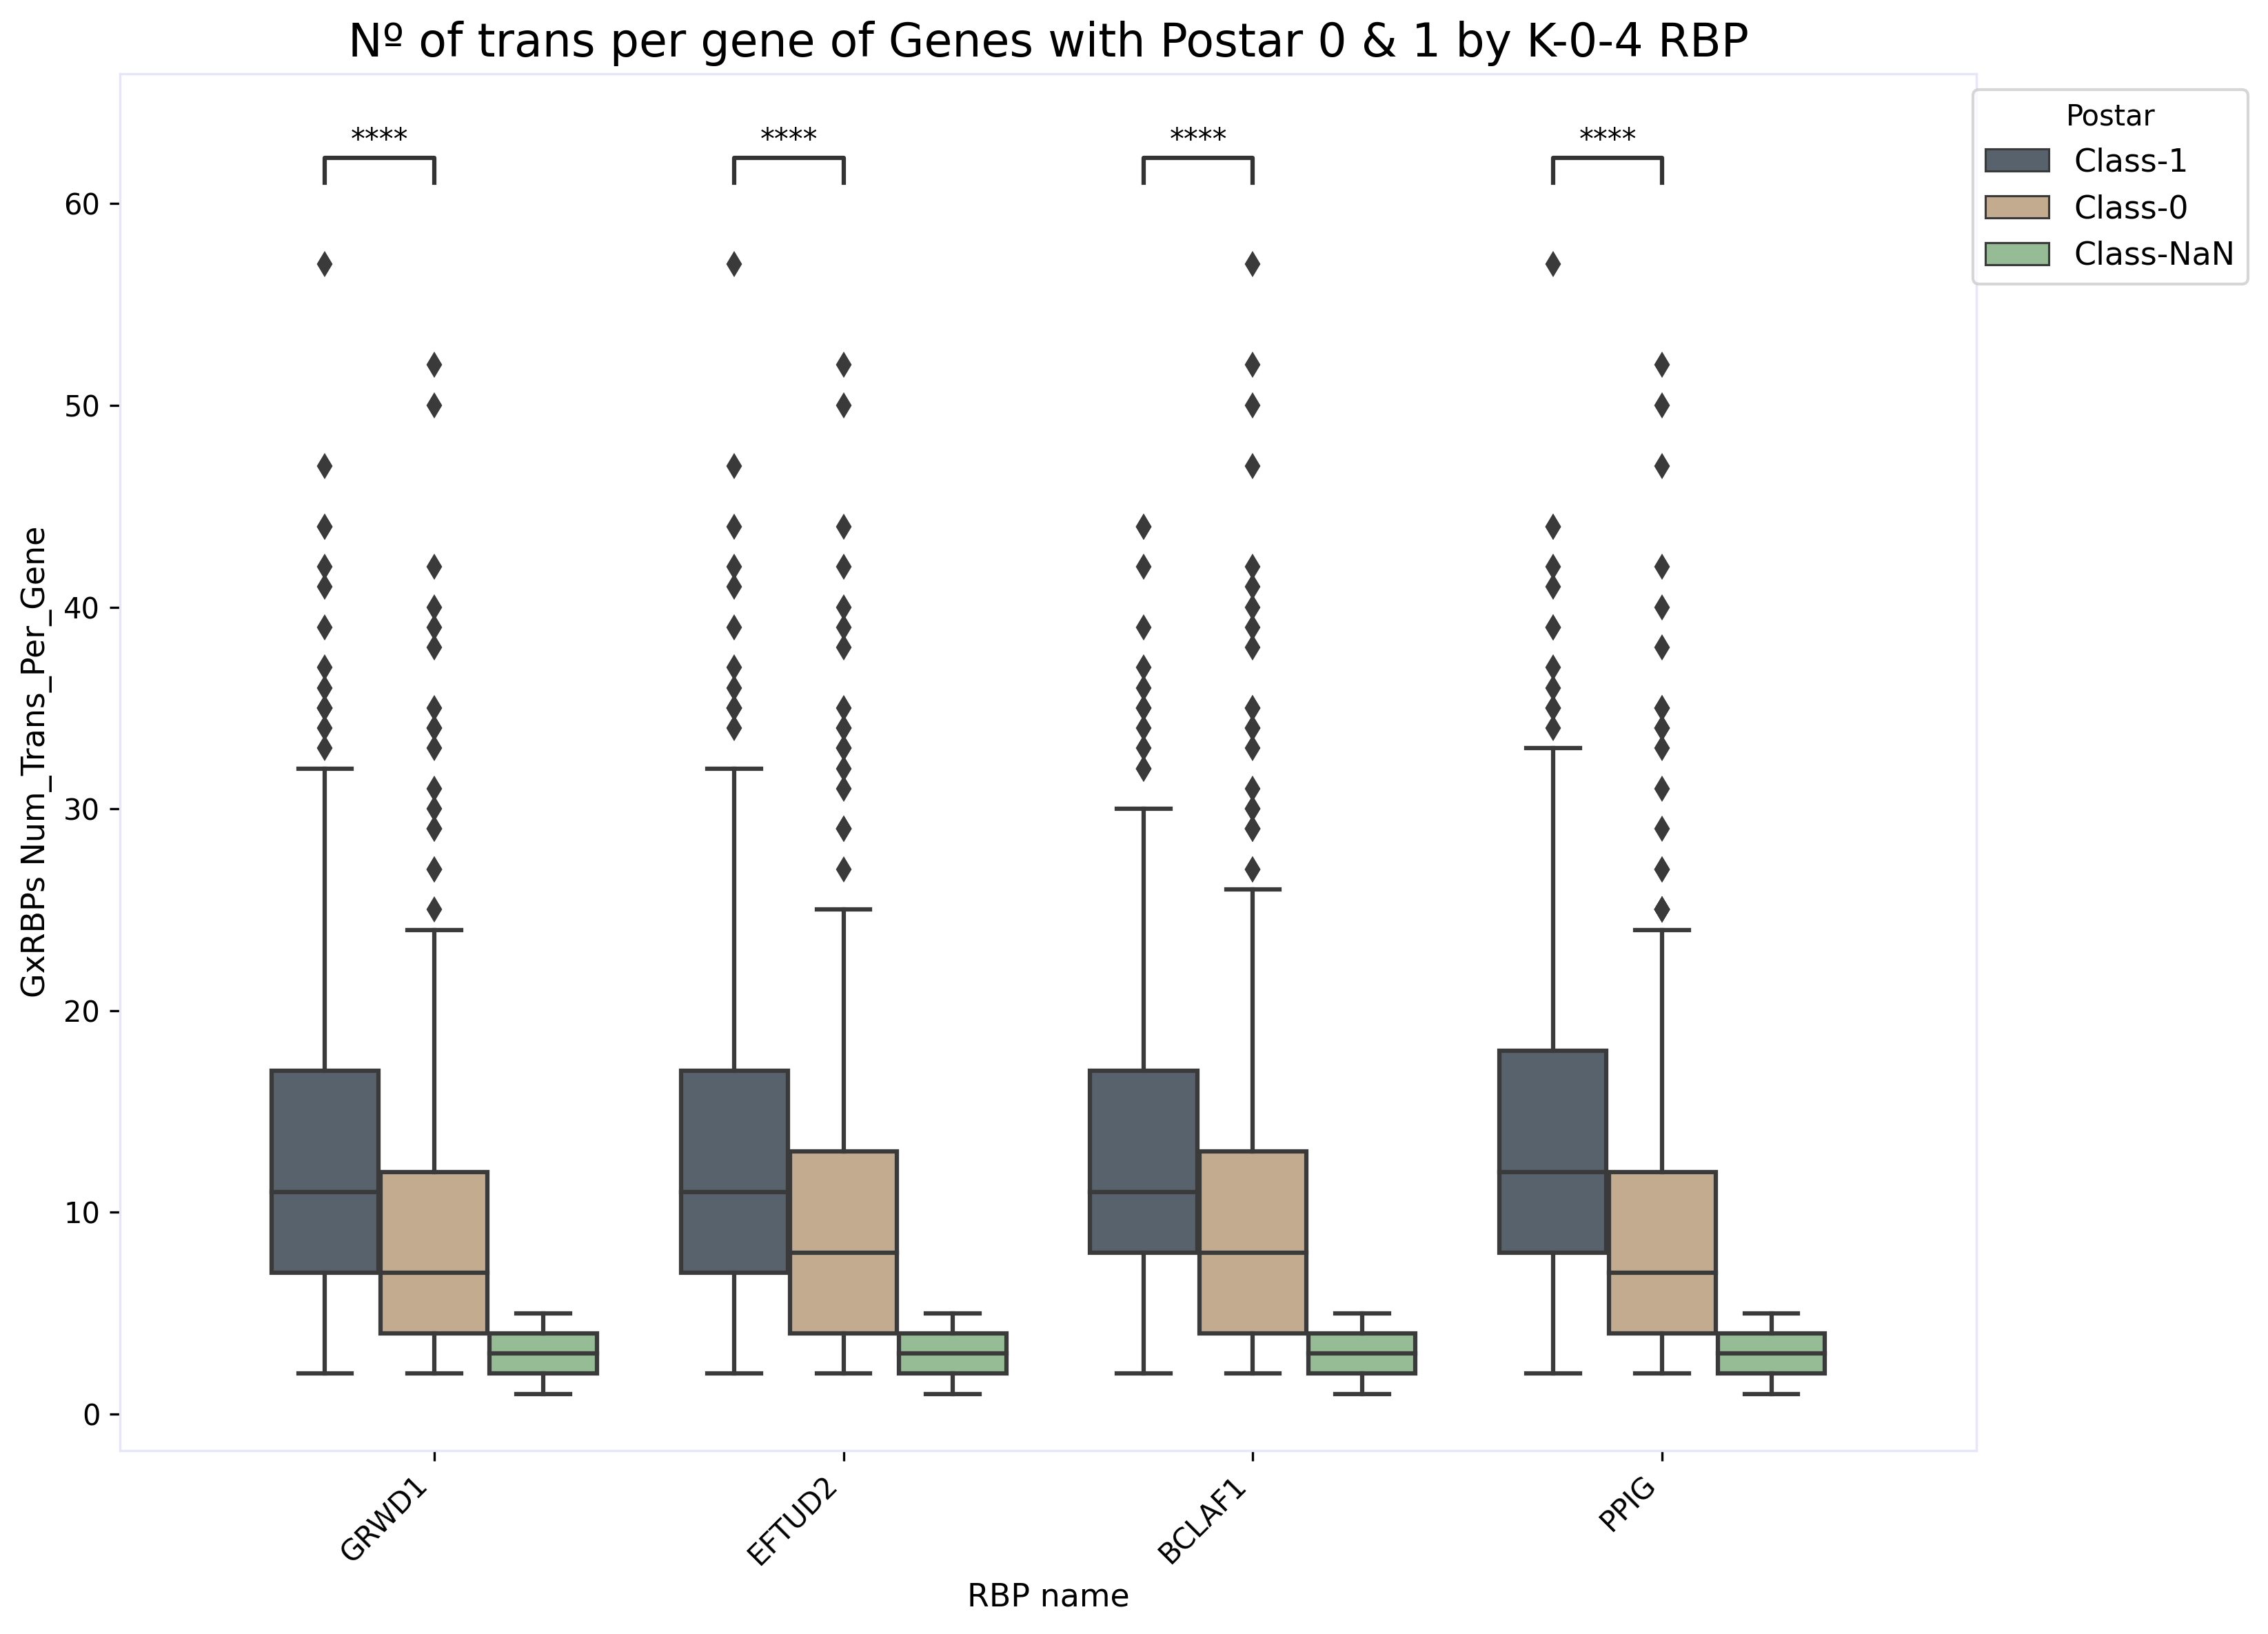

In [96]:
plot_score_results(list_rbps_postar, list_genes_postar, df_combined1, df_combined2, path_save)

## Calculate thesholds

[calculate_optimal_thresholds_per_rbp] Calculating optimal thresholds per RBP...
GRWD1


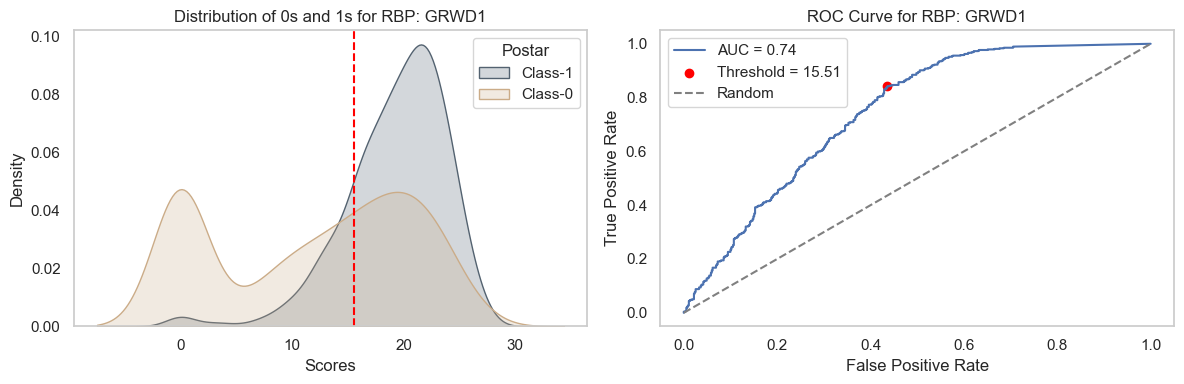

EFTUD2


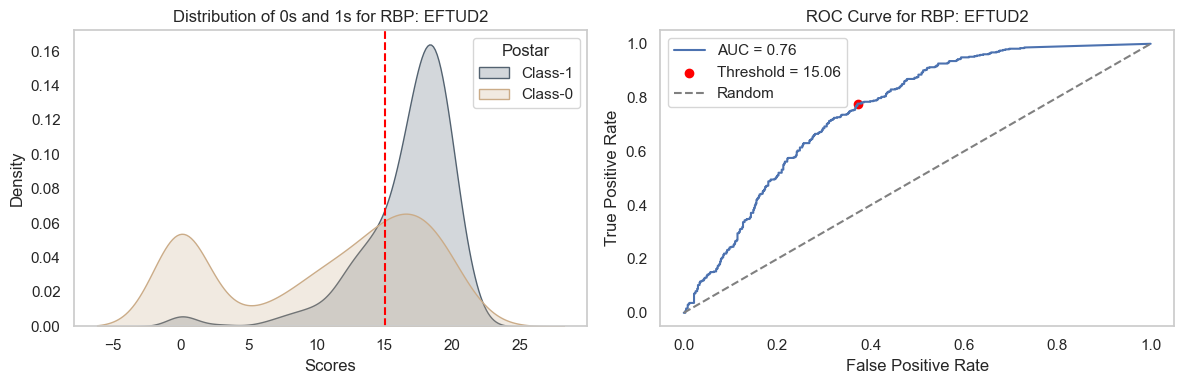

BCLAF1


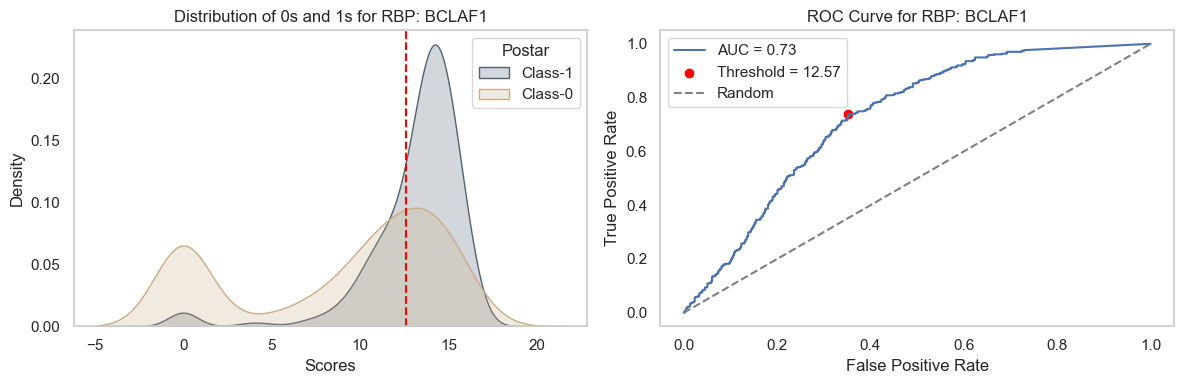

PPIG


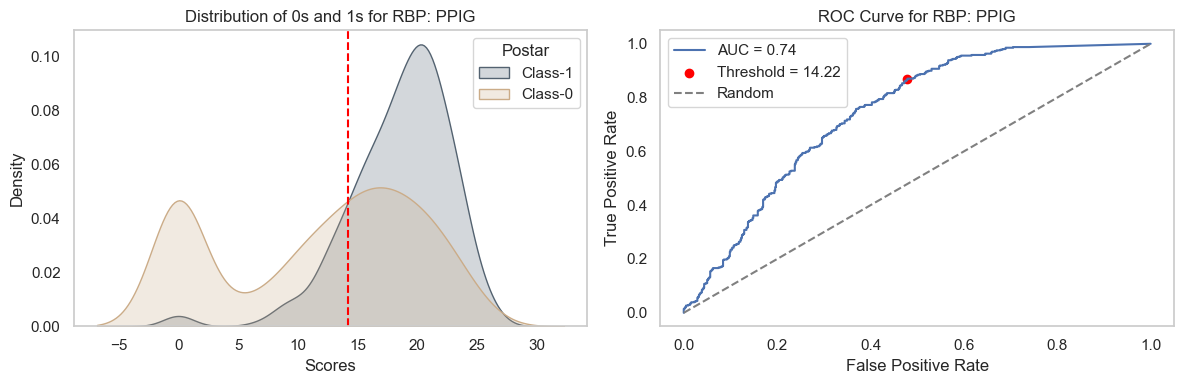

Results saved to: ./tutorial_2/results/optimal_thresholds.csv


In [102]:
df_combined1_without_nan = df_combined1[df_combined1.Postar.isin([0,1])] 
optimal_thresholds_df = calculate_optimal_thresholds_per_rbp(df_combined1_without_nan, path_save)